# Data Exploration and Formatting

Now that we've imported the data, cleaned the data, and saved it to a new file, we need to format it correctly for our machine learning process. 

## Steps

While the data has been cleaned, we need the data to have a "full" shape for our process. This means that we have to deal with the following issues:

- Providers without observations in certain data years
- Providers without observations for certain HCPCS codes

To do this, we will import the cleaned data, and then we'll do some manipulation with `pandas` to get the "full" shape we need. However, the current cleaned data set has: 
- $N_{\text{Providers}} = $ 1,069,492 unique providers,
- $N_{\text{Years}} =$ 8 years of data,
- and $N_{\text{HCPCS codes}} =$ 100 distinct codes.

If we kept the data at this scale and tried to sculpt the "full-shaped" version, the size of the data frame would need to be $N_{\text{Providers}} \times N_{\text{Years}} \times N_{\text{HCPCS codes}} =$ 855,593,600 rows. Instead, we will first do a bit of work understanding provider types and HCPCS codes, and then we will use this to determine how we can filter our data to feed it into the machine learning process.

Once we filter our data, we will format it in the shape mentioned above, and we will wrap up by factorizing the variables that will become the axes of our matrices in the machine learning process: provider NPI, data year, and HCPCS code. 

### Importing the Data

Instead of downloading from [data.cms.gov](https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service), this time we can load in the cleaned file. First, let's import the modules we need and check our current working directory.

In [1]:
# Import the os module
import os
import gc
import pandas as pd
os.getcwd()

'/geode2/home/u010/ausknies/Carbonate/Desktop/Erdos Fall 2022 Project'

Cool; now let's load in the cleaned data, stored as a `.csv` file in our project folder.

In [2]:
dfmain = pd.read_csv("dfmain.csv")
del dfmain[dfmain.columns[0]] # removes index column
dfmain.head()

,Rndrng_NPI,Rndrng_Prvdr_Type,HCPCS_Cd,Data_Year,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt
0,1003000142,Anesthesiology,99204,2013,0.292887,214.000000,122.981571
1,1003000142,Anesthesiology,99214,2013,0.707113,166.284024,79.205621
2,1003000423,Obstetrics/Gynecology,81002,2013,0.181818,10.000000,3.196667
3,1003000423,Obstetrics/Gynecology,99213,2013,0.323232,90.000000,51.410313
4,1003000423,Obstetrics/Gynecology,G0101,2013,0.292929,80.000000,36.300690


In [3]:
print("Total number of observations:")
print(dfmain['Data_Year'].count())
print("Total number of unique providers:")
print(dfmain['Rndrng_NPI'].nunique())
print("Total number of unique provider types:")
print(dfmain['Rndrng_Prvdr_Type'].nunique())
print("Total number of unique HCPCS codes:")
print(dfmain['HCPCS_Cd'].nunique())
print("Total number of unique data years:")
print(dfmain['Data_Year'].nunique())

Total number of observations:
29672609
Total number of unique providers:
1069492
Total number of unique provider types:
124
Total number of unique HCPCS codes:
100
Total number of unique data years:
8


### Exploring Properties of Provider Types and HCPCS Codes

Before we do anything else, it will first be helpful to determine whether provider types are constant for providers, or if they change across years. If they change, how often and how frequent? Let's check.

In [4]:
# check that each provider only has one type
dftype = dfmain.groupby(['Rndrng_NPI']).agg({'Rndrng_Prvdr_Type': pd.Series.nunique})

In [5]:
dftype['Rndrng_Prvdr_Type'].value_counts()

1    898348
2    162528
3      7959
4       642
5        15
Name: Rndrng_Prvdr_Type, dtype: int64

Indeed, there is some change in provider type at the provider level. The majority have just one type, but there are many providers in the sample who have at least 2 different types attached to their NPI. Since heterogeneity of providers is something we want to keep track of, let's confirm that our data is structured the way we believe to be by at least confirming that each provider type is unique to the provider-year pair.

In [6]:
# is it at least unique at the provider-year level?
dftype = dfmain.groupby(['Rndrng_NPI','Data_Year']).agg({'Rndrng_Prvdr_Type': pd.Series.nunique})

In [7]:
dftype['Rndrng_Prvdr_Type'].value_counts()

1    5414438
Name: Rndrng_Prvdr_Type, dtype: int64

So each provider type is not necessarily the same across years for a given provider, but the type is unique to the provider-year pair. 

Now, what do we know about provider types? Are most providers one particular type, or is there dispersment? This is an important question for understanding how we should deal with type heterogeneity in the machine learning process to come, so let's now group by type and figure things out.

In [8]:
# how many providers are of each type
dftype = dfmain.groupby('Rndrng_Prvdr_Type').agg({'Rndrng_NPI': pd.Series.nunique,'Data_Year':pd.Series.nunique})

In [9]:
dftype = dftype.rename(columns={"Rndrng_NPI":"No_of_Prvdrs","Data_Year":"No_of_Years_Apprd"})# rename

In [10]:
pd.set_option('display.max_rows', 15)
dftype.sort_values(by='No_of_Prvdrs', ascending=False)

,No_of_Prvdrs,No_of_Years_Apprd
Rndrng_Prvdr_Type,,
Nurse Practitioner,147032,8
Family Practice,100603,8
Internal Medicine,84693,8
Physical Therapist in Private Practice,81011,5
Physician Assistant,73666,8
...,...,...
Mammography Center,3,5
Ambulance Service Provider,3,5
Registered Dietician/Nutrition Professional,3,3


Within the top 5, there are 4 provider types that dominate the distribution and appear in all 8 years of data: **Nurse Practitioner**, **Family Practice**,**Internal Medicine**, and **Physician Assistant**. 

Let's take a look at the distribution of HCPCS coding by provider type.

In [11]:
del dftype
gc.collect()
# filter by providers who use all HCPCS codes
dfhcpcs = dfmain.groupby(['Rndrng_Prvdr_Type'], as_index=False).agg({'HCPCS_Cd': pd.Series.nunique})

In [12]:
dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type'].isin(['Nurse Practitioner','Internal Medicine','Family Practice','Physician Assistant'])]

,Rndrng_Prvdr_Type,HCPCS_Cd
34,Family Practice,98
52,Internal Medicine,98
72,Nurse Practitioner,100
94,Physician Assistant,100


It seems that these provider types certainly drive the HCPCS coding we have filtered by already in the previous steps. Let's explore how these HCPCS distributions look by each provider type a bit more.

In [13]:
dfhcpcs = dfmain[['Rndrng_Prvdr_Type','HCPCS_Cd']]

In [14]:
# Let's just look at top 4
dfhcpcs = dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type'].isin(['Nurse Practitioner','Internal Medicine','Family Practice','Physician Assistant'])]
dfhcpcs

,Rndrng_Prvdr_Type,HCPCS_Cd
6,Family Practice,G0179
7,Internal Medicine,81002
8,Internal Medicine,90662
9,Internal Medicine,90732
10,Internal Medicine,93000
...,...,...
29672598,Internal Medicine,99214
29672599,Internal Medicine,G0008
29672600,Internal Medicine,G0009
29672601,Internal Medicine,G0438


array([<AxesSubplot:title={'center':'Family Practice'}>,
       <AxesSubplot:title={'center':'Internal Medicine'}>,
       <AxesSubplot:title={'center':'Nurse Practitioner'}>,
       <AxesSubplot:title={'center':'Physician Assistant'}>], dtype=object)

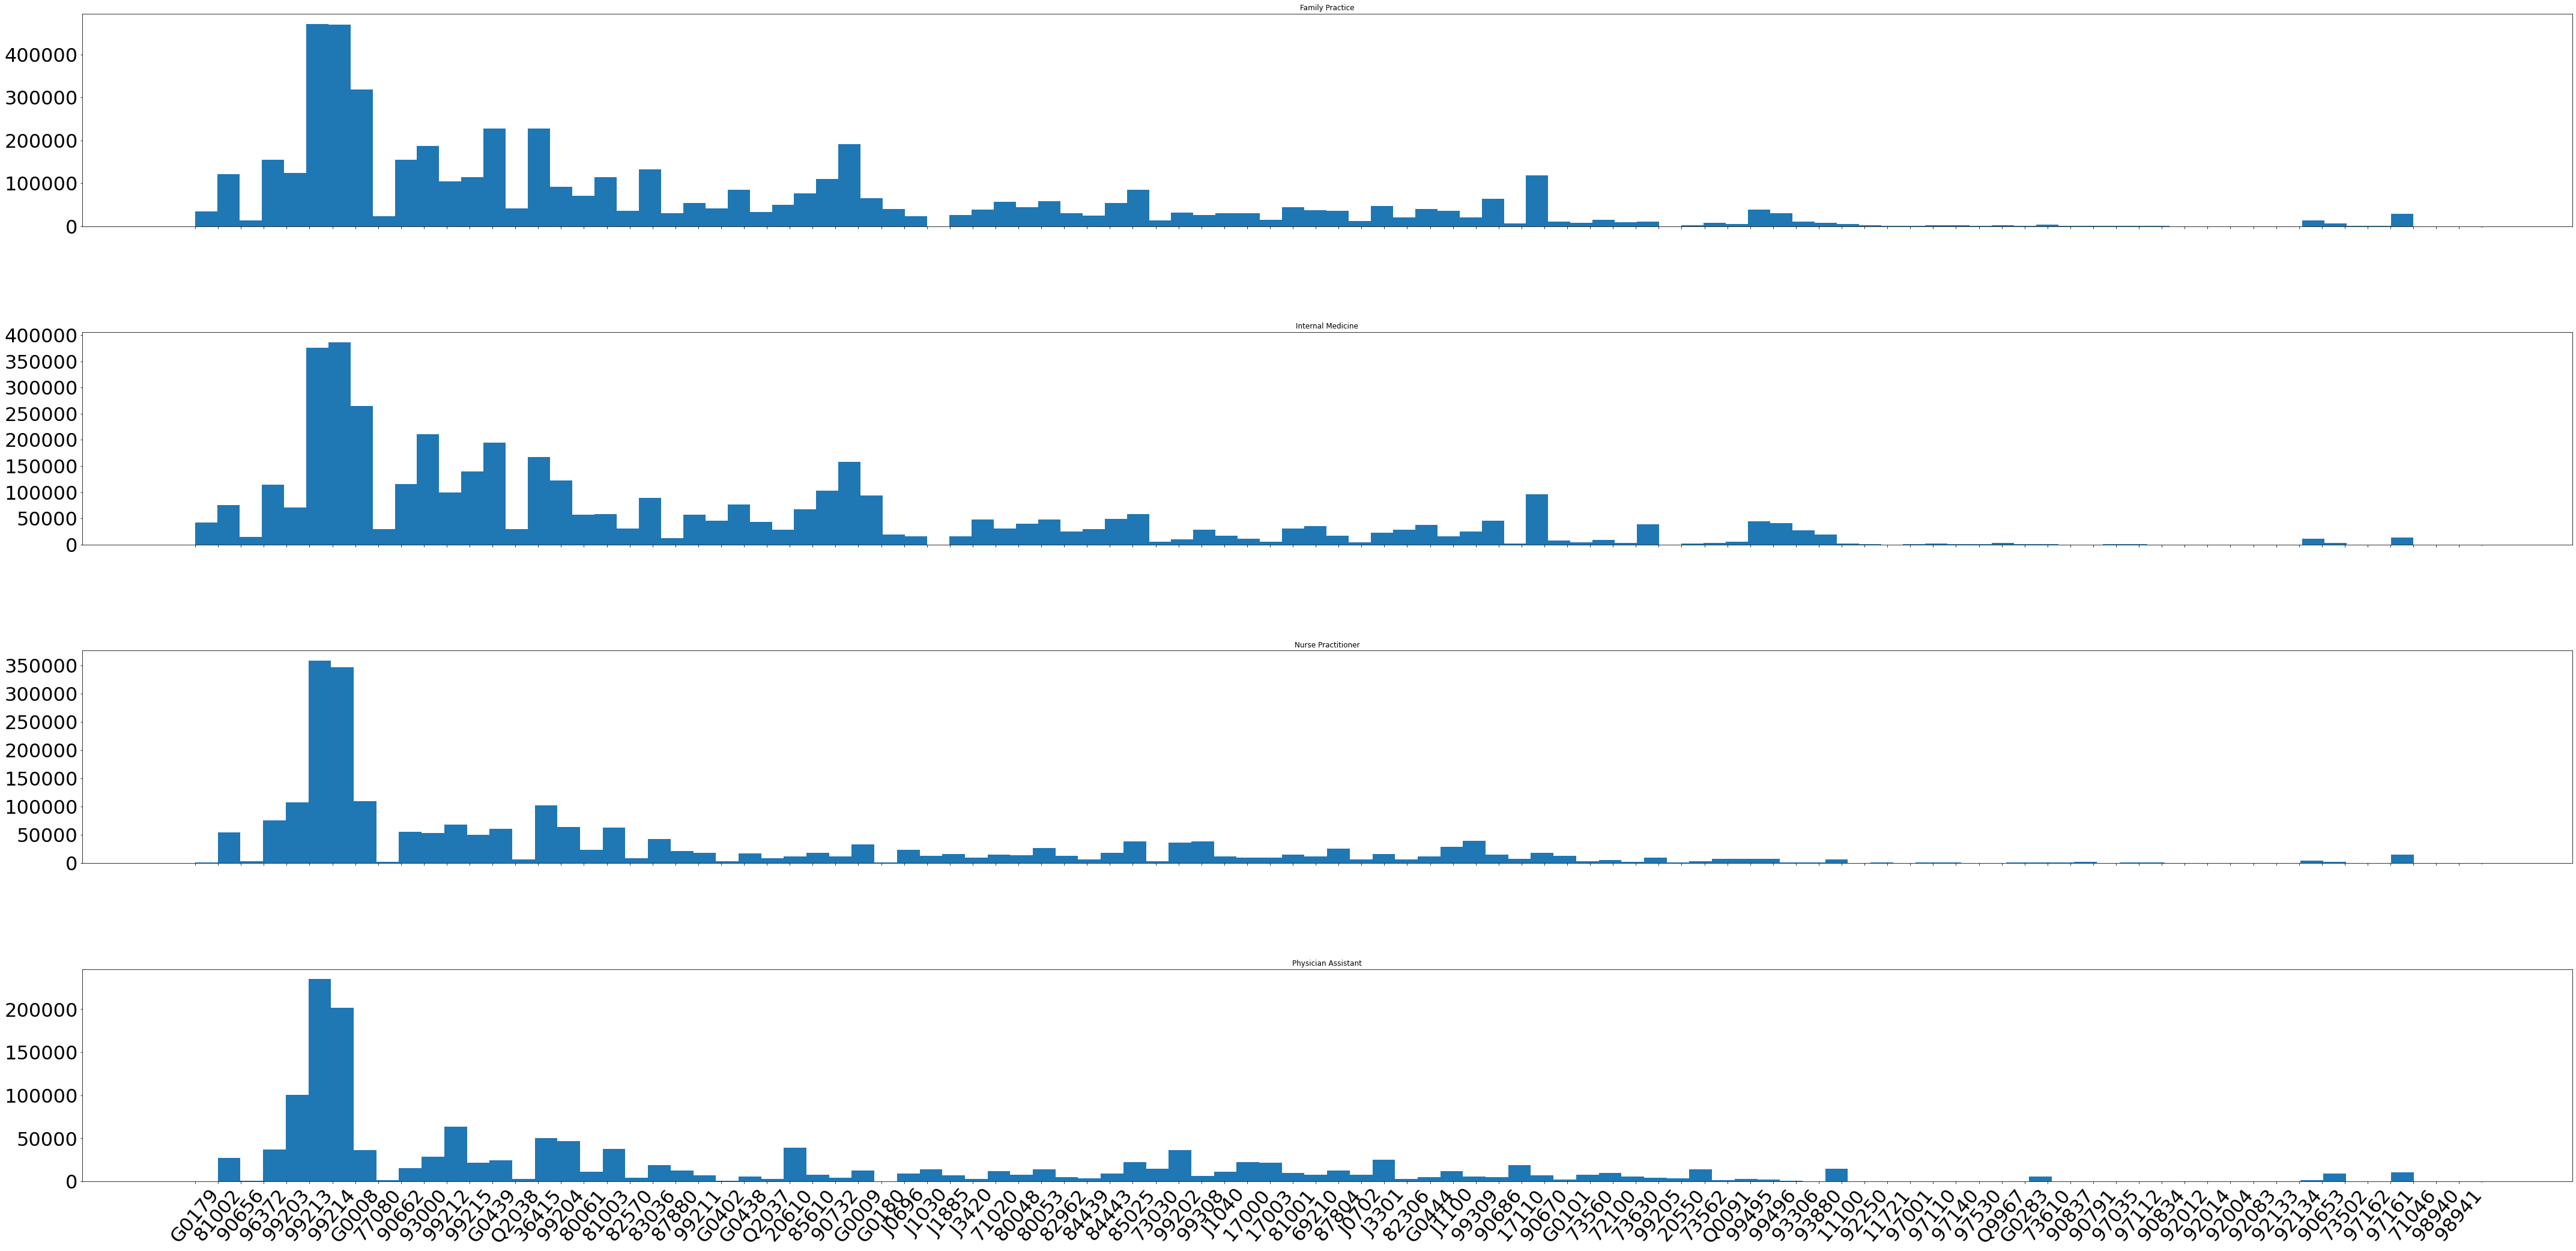

In [15]:
dfhcpcs.hist(column='HCPCS_Cd', by='Rndrng_Prvdr_Type',bins=100,xlabelsize=32,xrot=50,ylabelsize=32,sharex=True,layout=(4,1),figsize=(72,36))

Visually, there are certainly some similarities in coding frequency across these types. Let's get the top 15 most frequent HCPCS code-provider-year pairs for each provider type.

In [16]:
dfhcpcs = dfhcpcs.groupby(['Rndrng_Prvdr_Type','HCPCS_Cd'], as_index=False).size()

In [17]:
dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type']=='Family Practice'].sort_values(by='size', ascending=False).head(15)

,Rndrng_Prvdr_Type,HCPCS_Cd,size
69,Family Practice,99213,470999
70,Family Practice,99214,469869
76,Family Practice,G0008,317974
84,Family Practice,G0439,227383
7,Family Practice,36415,227114
77,Family Practice,G0009,190885
51,Family Practice,93000,187293
37,Family Practice,90662,155022
54,Family Practice,96372,154471
28,Family Practice,83036,132765


In [18]:
dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type']=='Internal Medicine'].sort_values(by='size', ascending=False).head(15)

,Rndrng_Prvdr_Type,HCPCS_Cd,size
168,Internal Medicine,99214,386002
167,Internal Medicine,99213,375752
174,Internal Medicine,G0008,264546
149,Internal Medicine,93000,210939
182,Internal Medicine,G0439,194315
105,Internal Medicine,36415,167619
175,Internal Medicine,G0009,158277
169,Internal Medicine,99215,140034
163,Internal Medicine,99204,122908
135,Internal Medicine,90662,115622


In [19]:
dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type']=='Nurse Practitioner'].sort_values(by='size', ascending=False).head(15)

,Rndrng_Prvdr_Type,HCPCS_Cd,size
267,Nurse Practitioner,99213,358470
268,Nurse Practitioner,99214,346838
274,Nurse Practitioner,G0008,109320
262,Nurse Practitioner,99203,107204
203,Nurse Practitioner,36415,102107
250,Nurse Practitioner,96372,75416
266,Nurse Practitioner,99212,68094
263,Nurse Practitioner,99204,64074
220,Nurse Practitioner,81003,62631
282,Nurse Practitioner,G0439,60429


In [20]:
dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type']=='Physician Assistant'].sort_values(by='size', ascending=False).head(15)

,Rndrng_Prvdr_Type,HCPCS_Cd,size
367,Physician Assistant,99213,234838
368,Physician Assistant,99214,201896
362,Physician Assistant,99203,100208
366,Physician Assistant,99212,63412
303,Physician Assistant,36415,50391
363,Physician Assistant,99204,46681
302,Physician Assistant,20610,38898
320,Physician Assistant,81003,37748
350,Physician Assistant,96372,36886
374,Physician Assistant,G0008,36304


For the four most prominent provider types, we now have a much better idea of HCPCS coding behavior. This will be extremely helpful in considering how to filter and format the data for the machine learning process to come.

What about the distribution of charges and service shares across provider types for each HCPCS code? Let's take a look at that.

In [21]:
dfhcpcs = dfmain.groupby(['Rndrng_Prvdr_Type','HCPCS_Cd'], as_index=False)[['Share_Srvcs','Avg_Sbmtd_Chrg','Avg_Mdcr_Pymt_Amt']].mean()

In [22]:
dfhcpcs = dfhcpcs[dfhcpcs['Rndrng_Prvdr_Type'].isin(['Nurse Practitioner','Internal Medicine','Family Practice','Physician Assistant'])]
dfhcpcs

,Rndrng_Prvdr_Type,HCPCS_Cd,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt
1695,Family Practice,11100,0.018035,174.082112,68.541039
1696,Family Practice,11721,0.032997,91.184384,31.160399
1697,Family Practice,17000,0.016997,136.476806,43.885940
1698,Family Practice,17003,0.017464,25.121254,4.468210
1699,Family Practice,17110,0.014282,195.309402,71.420011
...,...,...,...,...,...
5191,Physician Assistant,J3420,0.043996,12.202243,1.670130
5192,Physician Assistant,Q0091,0.147413,77.729354,36.433468
5193,Physician Assistant,Q2037,0.040429,27.345969,15.225055
5194,Physician Assistant,Q2038,0.046885,25.355241,12.262078


Let's plot these averages on a scatter plot by provider type. We'll enlist the help of `matplotlib` to do so.

In [23]:
import matplotlib.pyplot as plt

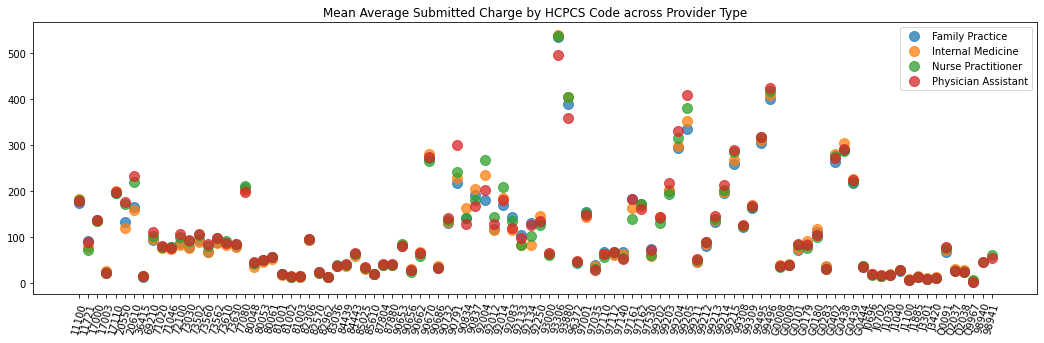

In [24]:
groups = dfhcpcs.groupby('Rndrng_Prvdr_Type')
fig, ax = plt.subplots(figsize=(18,5))
 
for name, group in groups:
    ax.plot(group.HCPCS_Cd, group.Avg_Sbmtd_Chrg, marker='o', linestyle='', ms=10, label=name,alpha=0.75)
ax.legend()
plt.title('Mean Average Submitted Charge by HCPCS Code across Provider Type')
plt.xticks(rotation = 75)
plt.show()

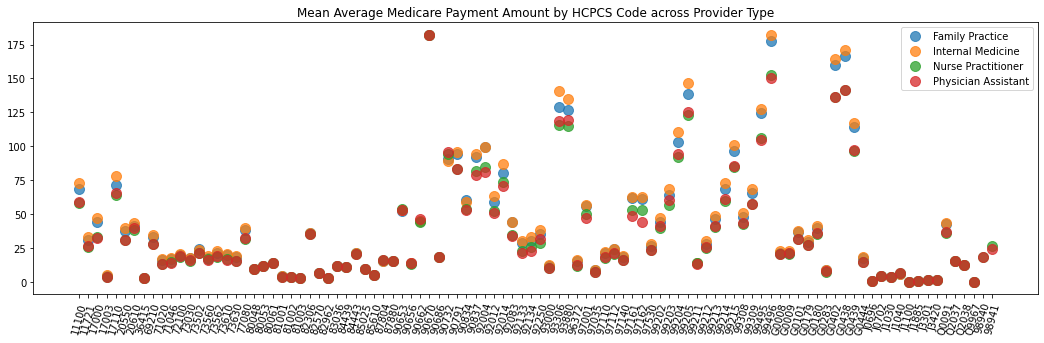

In [25]:
groups = dfhcpcs.groupby('Rndrng_Prvdr_Type')
fig, ax = plt.subplots(figsize=(18,5))
 
for name, group in groups:
    ax.plot(group.HCPCS_Cd, group.Avg_Mdcr_Pymt_Amt, marker='o', linestyle='', ms=10, label=name,alpha=0.75)
ax.legend()
plt.title('Mean Average Medicare Payment Amount by HCPCS Code across Provider Type')
plt.xticks(rotation = 75)
plt.show()

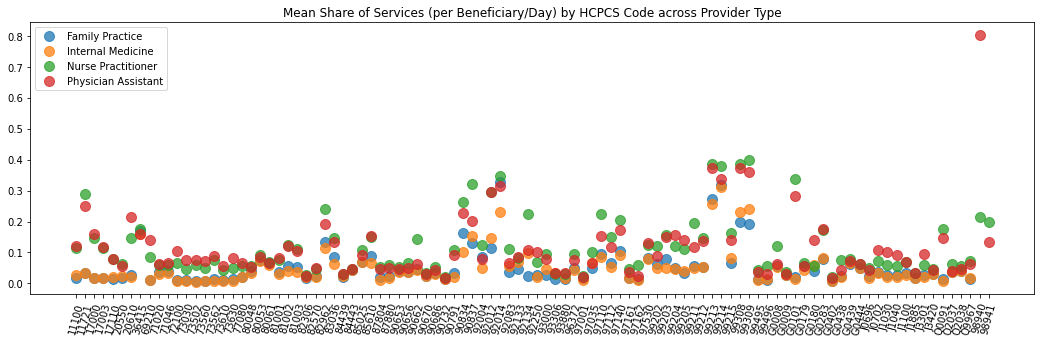

In [26]:
groups = dfhcpcs.groupby('Rndrng_Prvdr_Type')
fig, ax = plt.subplots(figsize=(18,5))
 
for name, group in groups:
    ax.plot(group.HCPCS_Cd, group.Share_Srvcs, marker='o', linestyle='', ms=10, label=name,alpha=0.75)
ax.legend()
plt.title('Mean Share of Services (per Beneficiary/Day) by HCPCS Code across Provider Type')
plt.xticks(rotation = 75)
plt.show()

Some observations from these plots:

- While mean average submitted charges are usually slightly higher for PAs and NPs, the Medicare payment amounts are slightly higher for Family Practice and Internal Medicine types. 
- Generally speaking, these mean charges are clustered together for each provider type.
- Mean share of services are higher for NPs and PAs than Family Practice and Internal Medicine.

In [27]:
del groups
del dfhcpcs

### Filtering the Data

Based on what we discovered in previous steps, in order to get our data into format that is ready and manageable for the machine learning process, we will take the following steps:

1. Limit observations to providers who appear in all (8) years of data
2. Limit observations to providers who never change provider type across all (8) years of data
3. Limit observations to providers in the top 4 provider types: 
    - Nurse Practioner
    - Internal Medicine
    - Family Practice
    - Physician Assistant

#### 1. Balanced Panel
For the first step, we will first determine how many years each distinct NPI shows up in the data, and then we will filter by only keeping providers who show up for the maximum amount of years (8).

In [28]:
# filter by providers who show up every year
dfprovs = dfmain.groupby(['Rndrng_NPI']).agg({'Data_Year': pd.Series.nunique})
dfprovs = dfprovs.rename(columns={"Data_Year":"No_of_Years"})

In [29]:
dfprovs = dfprovs[dfprovs['No_of_Years']==8]

In [30]:
dfprovslist = dfprovs.index.tolist()
len(dfprovslist)

366277

So, out of the 1,069,492 unique providers from the cleaned data, only 366,277 providers appear across all 8 years of our data. Let's filter our cleaned data down to these providers.

In [31]:
dfmain = dfmain[dfmain['Rndrng_NPI'].isin(dfprovslist)]

Alright. Let's see how this impacts our cleaned data frame.

In [32]:
print("Total number of observations:")
print(dfmain['Data_Year'].count())
print("Total number of unique providers:")
print(dfmain['Rndrng_NPI'].nunique())
print("Total number of unique provider types:")
print(dfmain['Rndrng_Prvdr_Type'].nunique())
print("Total number of unique HCPCS codes:")
print(dfmain['HCPCS_Cd'].nunique())
print("Total number of unique data years:")
print(dfmain['Data_Year'].nunique())

Total number of observations:
19446488
Total number of unique providers:
366277
Total number of unique provider types:
118
Total number of unique HCPCS codes:
100
Total number of unique data years:
8


To get the balanced panel, we've dropped roughly 10 million observations, and we're down to 366,277 unique providers and 118 provider types, but everything else is the same. Let's move on to the next filtering step.

In [33]:
del dfprovs
del dfprovslist

#### 2. Same-Type Providers

In this step, we will determine how many provider types are associated with a given NPI, and then I will filter out NPIs that ever change types across years. We did this calculation previously, so it will be easily to implement again!

In [34]:
dftype = dfmain.groupby(['Rndrng_NPI']).agg({'Rndrng_Prvdr_Type': pd.Series.nunique})
dftype = dftype.rename(columns={"Rndrng_Prvdr_Type":"No_of_Types"})

In [35]:
dftype = dftype[dftype['No_of_Types']==1]

In [36]:
dftypelist = dftype.index.tolist()
len(dftypelist)

273544

So out of 366,277 unique providers who appear all 8 years in our data, only 273,544 of them keep the same type all 8 years. Let's filter down our data further to these providers.

In [37]:
dfmain = dfmain[dfmain['Rndrng_NPI'].isin(dftypelist)]

Again, let's compare where we are now to before.

In [38]:
print("Total number of observations:")
print(dfmain['Data_Year'].count())
print("Total number of unique providers:")
print(dfmain['Rndrng_NPI'].nunique())
print("Total number of unique provider types:")
print(dfmain['Rndrng_Prvdr_Type'].nunique())
print("Total number of unique HCPCS codes:")
print(dfmain['HCPCS_Cd'].nunique())
print("Total number of unique data years:")
print(dfmain['Data_Year'].nunique())

Total number of observations:
15641636
Total number of unique providers:
273544
Total number of unique provider types:
61
Total number of unique HCPCS codes:
100
Total number of unique data years:
8


We dropped just under 4 million observations, going from 118 unique provider types now to only 61. We have also wittled down our number of unique providers by 121,212. Let's keep filtering.

In [39]:
del dftype
del dftypelist
gc.collect()

22265

#### 3. Top 4 Types 

Now, we'll go further and limit our balanced panel of constant-type providers to just 4 provider types:

- Nurse Practioner
- Internal Medicine
- Family Practice
- Physician Assistant

Let's see how this impacts us.

In [40]:
dfmain = dfmain[dfmain['Rndrng_Prvdr_Type'].isin(['Nurse Practitioner','Internal Medicine','Family Practice','Physician Assistant'])]

Now, let's see what that has changed for us.

In [41]:
print("Total number of observations:")
print(dfmain['Data_Year'].count())
print("Total number of unique providers:")
print(dfmain['Rndrng_NPI'].nunique())
print("Total number of unique provider types:")
print(dfmain['Rndrng_Prvdr_Type'].nunique())
print("Total number of unique HCPCS codes:")
print(dfmain['HCPCS_Cd'].nunique())
print("Total number of unique data years:")
print(dfmain['Data_Year'].nunique())

Total number of observations:
8337046
Total number of unique providers:
100645
Total number of unique provider types:
4
Total number of unique HCPCS codes:
100
Total number of unique data years:
8


In filtering by top 4 provider types in our balanced panel of constant-type providers, this took us to 8,337,046 observations. We also went to just 100,645 providers.

And that's it for filtering the data! Before we move to formatting, let's check one last thing: how many unique providers are in the provider type categories we have chosen, now that we have filtered out a balanced panel?

In [42]:
# how many providers are of each type
dftype = dfmain.groupby('Rndrng_Prvdr_Type').agg({'Rndrng_NPI': pd.Series.nunique})
dftype

,Rndrng_NPI
Rndrng_Prvdr_Type,
Family Practice,40315
Internal Medicine,34147
Nurse Practitioner,15179
Physician Assistant,11004


Also, let's get the top 100 HCPCS codes in order again and saved to a list. This will be helpful for a later step.

In [43]:
top100codes = dfmain['HCPCS_Cd'].value_counts().nlargest(100).index.tolist()
top100codes

['99213',
 '99214',
 'G0008',
 'G0439',
 '93000',
 '36415',
 'G0009',
 '96372',
 '90662',
 '99215',
 '99212',
 '83036',
 '99203',
 '90670',
 '90732',
 '81002',
 '99204',
 '81003',
 'G0438',
 '85025',
 'G0180',
 '85610',
 '80061',
 '80053',
 '90686',
 '99211',
 '84443',
 '20610',
 'J3420',
 'G0402',
 '71020',
 '80048',
 'J3301',
 '99495',
 'G0444',
 '69210',
 '81001',
 'Q2037',
 '99496',
 'G0179',
 'J0696',
 'Q2038',
 '82570',
 'J1100',
 '99202',
 '87804',
 '17000',
 '84439',
 'J1040',
 '99308',
 '77080',
 '82962',
 '82306',
 'J1885',
 'J1030',
 '87880',
 '99309',
 '71046',
 '99205',
 '17003',
 '93306',
 '72100',
 '93880',
 '73030',
 '90656',
 '90653',
 'G0101',
 '17110',
 'J0702',
 '73562',
 '11100',
 '73560',
 'Q0091',
 '73630',
 '73502',
 '73610',
 '20550',
 'Q9967',
 '97110',
 '92250',
 '97140',
 '97112',
 'G0283',
 '97035',
 '11721',
 '97001',
 '97530',
 '90791',
 '90834',
 '90837',
 '97162',
 '97161',
 '92012',
 '92014',
 '92083',
 '92004',
 '92133',
 '92134',
 '98941',
 '98940']

Cool! Let's move to data formatting.

### Formatting the Data

To reshape the data, I'm going to create a new data frame with one row for each possible provider, data year, and HCPCS code. Then I will merge in our current cleaned data with this artificially constructed data frame, and when there are missing values for the characteristics that we want to use, we'll replace missing values with zeroes. Remember, it's these:

1. Share of total services (beneficiary per day) provided
2. Average submitted charge
3. Average Medicare payment amount


Alright, so first, let's extract all the possible values of NPIs, years, and HCPCS codes from the cleaned data.

In [44]:
NPI = dfmain['Rndrng_NPI'].unique()
year = dfmain['Data_Year'].unique()
code = dfmain['HCPCS_Cd'].unique()

In [45]:
# check one of these to make sure it's good to go
print("Number of distinct providers:",len(NPI))
print("Number of data years:",len(year))
print("Number of HCPCS codes:",len(code))

Number of distinct providers: 100645
Number of data years: 8
Number of HCPCS codes: 100


Now, we'll use these arrays to create an artificial data frame with the shape we want. To do this, we need to make sure the rows of the data frame contain every possible combination of provider index, data year, and HCPCS code. In other words, the size of the data frame needs to be $N_{\text{Providers}} \times N_{\text{Years}} \times N_{\text{HCPCS codes}} =$ 80,516,000 rows.

In [46]:
from itertools import product
dfshaped = pd.DataFrame(list(product(NPI, year, code)), columns=['Rndrng_NPI', 'Data_Year', 'HCPCS_Cd'])

In [47]:
dfshaped

,Rndrng_NPI,Data_Year,HCPCS_Cd
0,1003000530,2013,81002
1,1003000530,2013,90662
2,1003000530,2013,90732
3,1003000530,2013,93000
4,1003000530,2013,99213
...,...,...,...
80515995,1992999551,2020,90653
80515996,1992999551,2020,73502
80515997,1992999551,2020,97162
80515998,1992999551,2020,97161


In [48]:
print(dfmain.isnull().values.any())
print(dfshaped.isnull().values.any())

False
False


Perfect. Now, what we'll do is merge the characteristics in our real and cleaned data frame into this data frame of all possible combinations. Let's do that now.

In [49]:
dfprovtype = dfmain[['Rndrng_NPI','Rndrng_Prvdr_Type']].drop_duplicates()
dfelse = dfmain[['Rndrng_NPI','Data_Year','HCPCS_Cd','Share_Srvcs','Avg_Sbmtd_Chrg','Avg_Mdcr_Pymt_Amt']]
del dfmain
gc.collect()

0

In [50]:
# Merge the observed data into the data frame of possible combinations
dfbloom = dfshaped.merge(dfprovtype, how='left', on='Rndrng_NPI')
del dfprovtype
del dfshaped
gc.collect()
dfbloom = dfbloom.merge(dfelse, how='left', on=['Rndrng_NPI','Data_Year','HCPCS_Cd'])
del dfelse
gc.collect()

0

In [51]:
dfbloom

,Rndrng_NPI,Data_Year,HCPCS_Cd,Rndrng_Prvdr_Type,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt
0,1003000530,2013,81002,Internal Medicine,0.016749,9.0,3.458235
1,1003000530,2013,90662,Internal Medicine,0.089655,75.0,30.802857
2,1003000530,2013,90732,Internal Medicine,0.010837,86.0,69.967273
3,1003000530,2013,93000,Internal Medicine,0.011823,75.0,13.683333
4,1003000530,2013,99213,Internal Medicine,0.200985,100.0,44.415294
...,...,...,...,...,...,...,...
80515995,1992999551,2020,90653,Internal Medicine,NaN,NaN,NaN
80515996,1992999551,2020,73502,Internal Medicine,NaN,NaN,NaN
80515997,1992999551,2020,97162,Internal Medicine,NaN,NaN,NaN
80515998,1992999551,2020,97161,Internal Medicine,NaN,NaN,NaN


Now, for the observations that are missing, we want to replace with zeros. This reflects the idea that for a given provider-year-HCPCS code that is unobserved in the real data (and therefore without matching values from the merge), the share of services should be 0%, and the average submitted and paid charges should also be zero. Let's replace missing values with zeros. 

In [52]:
dfbloom = dfbloom.fillna(0)

In [53]:
dfbloom

,Rndrng_NPI,Data_Year,HCPCS_Cd,Rndrng_Prvdr_Type,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt
0,1003000530,2013,81002,Internal Medicine,0.016749,9.0,3.458235
1,1003000530,2013,90662,Internal Medicine,0.089655,75.0,30.802857
2,1003000530,2013,90732,Internal Medicine,0.010837,86.0,69.967273
3,1003000530,2013,93000,Internal Medicine,0.011823,75.0,13.683333
4,1003000530,2013,99213,Internal Medicine,0.200985,100.0,44.415294
...,...,...,...,...,...,...,...
80515995,1992999551,2020,90653,Internal Medicine,0.000000,0.0,0.000000
80515996,1992999551,2020,73502,Internal Medicine,0.000000,0.0,0.000000
80515997,1992999551,2020,97162,Internal Medicine,0.000000,0.0,0.000000
80515998,1992999551,2020,97161,Internal Medicine,0.000000,0.0,0.000000


Great! Our data is almost ready for the algorithm. We have one final task, which is to turn provider, year, and HCPCS codes into ordinal values. These values will be used as dimensions for the matrices used in the machine learning algorithm. First, let's sort by HCPCS code frequency, and then let's create new variables.

In [54]:
dfbloom.HCPCS_Cd = dfbloom.HCPCS_Cd.astype("category")
dfbloom.HCPCS_Cd = dfbloom.HCPCS_Cd.cat.set_categories(top100codes)
dfbloom = dfbloom.sort_values(['Rndrng_NPI','Data_Year','HCPCS_Cd'])

Alright, let's check it out.

In [55]:
dfbloom

,Rndrng_NPI,Data_Year,HCPCS_Cd,Rndrng_Prvdr_Type,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt
4,1003000530,2013,99213,Internal Medicine,0.200985,100.0,44.415294
5,1003000530,2013,99214,Internal Medicine,0.497537,150.0,66.173644
7,1003000530,2013,G0008,Internal Medicine,0.115271,30.0,26.793504
25,1003000530,2013,G0439,Internal Medicine,0.000000,0.0,0.000000
3,1003000530,2013,93000,Internal Medicine,0.011823,75.0,13.683333
...,...,...,...,...,...,...,...
80515987,1992999551,2020,92004,Internal Medicine,0.000000,0.0,0.000000
80515991,1992999551,2020,92133,Internal Medicine,0.000000,0.0,0.000000
80515992,1992999551,2020,92134,Internal Medicine,0.000000,0.0,0.000000
80515993,1992999551,2020,98941,Internal Medicine,0.000000,0.0,0.000000


Cool! Now, all that's left to do is create new variables with ordinal values for provider, year, and HCPCS code dimensions.

In [56]:
dfbloom['provindex'] = pd.factorize(dfbloom.Rndrng_NPI)[0]
dfbloom['yearindex'] = pd.factorize(dfbloom.Data_Year)[0]
dfbloom['hcpcsindex'] = pd.factorize(dfbloom.HCPCS_Cd)[0]

In [57]:
dfbloom

,Rndrng_NPI,Data_Year,HCPCS_Cd,Rndrng_Prvdr_Type,Share_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Pymt_Amt,provindex,yearindex,hcpcsindex
4,1003000530,2013,99213,Internal Medicine,0.200985,100.0,44.415294,0,0,0
5,1003000530,2013,99214,Internal Medicine,0.497537,150.0,66.173644,0,0,1
7,1003000530,2013,G0008,Internal Medicine,0.115271,30.0,26.793504,0,0,2
25,1003000530,2013,G0439,Internal Medicine,0.000000,0.0,0.000000,0,0,3
3,1003000530,2013,93000,Internal Medicine,0.011823,75.0,13.683333,0,0,4
...,...,...,...,...,...,...,...,...,...,...
80515987,1992999551,2020,92004,Internal Medicine,0.000000,0.0,0.000000,100644,7,95
80515991,1992999551,2020,92133,Internal Medicine,0.000000,0.0,0.000000,100644,7,96
80515992,1992999551,2020,92134,Internal Medicine,0.000000,0.0,0.000000,100644,7,97
80515993,1992999551,2020,98941,Internal Medicine,0.000000,0.0,0.000000,100644,7,98


Awesome! We're ready to do some machine learning. Let's save our cleaned data file for the algorithm.

In [58]:
dfbloom.to_csv("dfbloom.csv") # save formatted data